In [188]:
import warnings
import numpy as np
import pandas as pd
import dcor
from sklearn import mixture

from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt
import seaborn as sns

In [483]:
df = pd.read_csv('7_blobs.csv')
df.head()

,x,y,Class
0,0.200092,0.712578,C1
1,0.179634,0.696056,C1
2,0.188313,0.696778,C1
3,0.207245,0.704485,C1
4,0.201645,0.700487,C1


In [484]:
warnings.filterwarnings('ignore')
examples = df[['x', 'y']][2:].convert_objects(convert_numeric=True).to_numpy()

In [485]:
examples *= 10

In [486]:
labels = df['Class'][2:].to_numpy()
labels[np.where(labels == 'C1')[0]] = 0
labels[np.where(labels == 'C2')[0]] = 1
labels[np.where(labels == 'C3')[0]] = 2
labels[np.where(labels == 'C4')[0]] = 3
labels[np.where(labels == 'C5')[0]] = 4
labels[np.where(labels == 'C6')[0]] = 5
labels[np.where(labels == 'C7')[0]] = 6

In [487]:
X, Y = np.s_[:,0], np.s_[:,1]

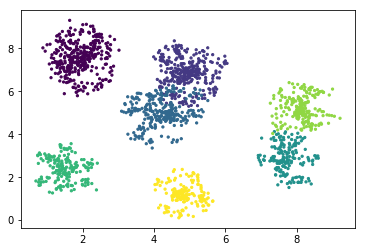

In [488]:
plt.scatter(examples[X], examples[Y], c=labels, s=5)
plt.show()

In [580]:
num_components = 7
g = mixture.GaussianMixture(n_components=num_components, covariance_type='diag')
g = g.fit(examples)

In [581]:
g.covariances_, g.means_

(array([[0.13620266, 0.25004926],
        [0.19315928, 0.37802809],
        [0.18793016, 0.52205032],
        [0.1266994 , 0.32655742],
        [0.14618795, 0.27621907],
        [0.26198089, 0.38288433],
        [0.12176376, 0.46476883]]), array([[4.84685783, 1.18151114],
        [4.92134912, 6.91683795],
        [1.92469667, 7.57552968],
        [8.14415164, 5.19946984],
        [1.48280518, 2.3761974 ],
        [4.22748559, 5.08666919],
        [7.72536999, 2.93663401]]))

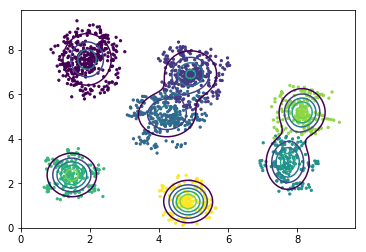

In [582]:
plt.scatter(examples[X], examples[Y], c=labels, s=5)

xs,  ys  = np.linspace(0, np.max(examples[X]), 100), np.linspace(0, np.max(examples[Y]), 100)
xxs, yys = np.meshgrid(xs, ys)

probas_sum = np.zeros((100, 100))

for mean, cov in zip(g.means_, g.covariances_):
    norm_dist = multivariate_normal(mean=mean, cov=cov)
    probas_sum += norm_dist.pdf(np.hstack([xxs.reshape(-1, 1), yys.reshape(-1, 1)])).reshape(100, 100)

probas_mean = probas_sum / num_components
plt.contour(xxs, yys, probas_mean)

plt.show()

## KL Divergence

In [518]:
def kl_divergence(mu1, mu2, sigma_1, sigma_2):
	sigma_diag_1 = np.eye(sigma_1.shape[0]) * sigma_1
	sigma_diag_2 = np.eye(sigma_2.shape[0]) * sigma_2

	sigma_diag_2_inv = np.linalg.inv(sigma_diag_2)

	kl = 0.5 * (np.log(np.linalg.det(sigma_diag_2) / np.linalg.det(sigma_diag_2))
				- mu1.shape[0] + np.trace(np.matmul(sigma_diag_2_inv, sigma_diag_1))
				+ np.matmul(np.matmul(np.transpose(mu2 - mu1), sigma_diag_2_inv), (mu2 - mu1))
				)

	return kl

In [531]:
mixture.GaussianMixture?

In [564]:
num_components = 2
for i in range(num_components):
    for j in range(num_components):
        if j > i:
            print('1')

1


In [578]:
num_repetitions = 30
max_min_ratios = []
comps_to_test = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

for num_components in tqdm_notebook(comps_to_test):
    
    local_max_min_ratios = []
    
    for i in range(num_repetitions):
        
        g = mixture.GaussianMixture(n_components=num_components, covariance_type='diag', n_init=10)
        g = g.fit(examples)
        
        klds = []

        for i in range(num_components):
            for j in range(num_components):
                if (j > i):
                    klds.append(kl_divergence(g.means_[i], g.means_[j], g.covariances_[i], g.covariances_[j]))

        local_max_min_ratios.append(np.max(klds) / np.min(klds))
        
    max_min_ratios.append(np.mean(local_max_min_ratios))

In [591]:
len(np.array(max_min_ratios)[1:])

10

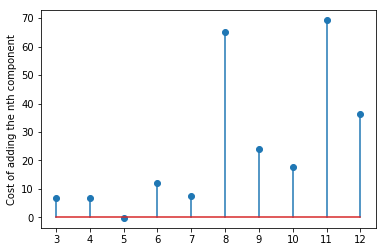

In [596]:
plt.stem(comps_to_test[1:], np.array(max_min_ratios)[1:] - np.array(max_min_ratios)[:-1])
plt.xticks(comps_to_test[1:])
plt.ylabel('Cost of adding the nth component')
plt.show()

## Energy distance

In [462]:
from tqdm import tqdm_notebook

In [507]:
num_samps = 10000

e_distance_max_min_ratios = []
comps_to_test = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for num_components in tqdm_notebook(comps_to_test):

    g = mixture.GaussianMixture(n_components=num_components, covariance_type='diag')
    g = g.fit(examples)

    samps = np.zeros((num_components, num_samps, 2))

    for i, (mean, cov) in enumerate(zip(g.means_, g.covariances_)):
        norm_dist = multivariate_normal(mean=mean, cov=cov)
        samps[i] = norm_dist.rvs(num_samps)

    e_distances_mat = np.zeros((num_components, num_components))
    e_distances = []
    for i in range(num_components):
        for j in range(num_components):
            if (j > i):
                e_distance = float(dcor.energy_distance(samps[i], samps[j]))
                e_distances.append(e_distance)
                e_distances_mat[i, j] = e_distance
                
    e_distance_max_min_ratios.append(np.max(e_distances) / np.min(e_distances))

KeyboardInterrupt: 

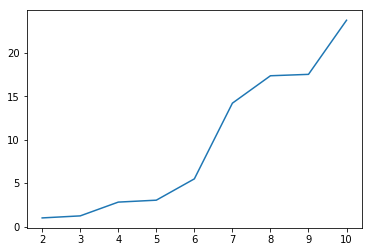

In [502]:
plt.plot(comps_to_test, e_distance_max_min_ratios)
plt.show()

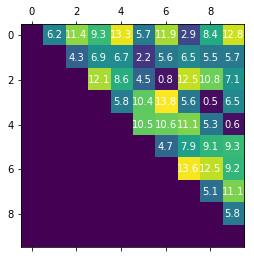

In [500]:
plt.matshow(e_distances_mat, cmap='viridis')
for (i, j), z in np.ndenumerate(e_distances_mat):
    if j > i:
        plt.text(j, i, '{:0.1f}'.format(z), color='white', ha='center', va='center')
plt.show()